In [1]:
#necessary imports

import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [2]:
#importing data using glob

csv_files = glob("./zippedData/*.csv.gz")
csv_files

['./zippedData/imdb.title.crew.csv.gz',
 './zippedData/tmdb.movies.csv.gz',
 './zippedData/imdb.title.akas.csv.gz',
 './zippedData/imdb.title.ratings.csv.gz',
 './zippedData/imdb.name.basics.csv.gz',
 './zippedData/imdb.title.basics.csv.gz',
 './zippedData/tn.movie_budgets.csv.gz',
 './zippedData/bom.movie_gross.csv.gz',
 './zippedData/imdb.title.principals.csv.gz']

In [3]:
csv_files_dict = {}
for filename in csv_files:
    filename_cleaned = os.path.basename(filename).replace(".csv", "").replace(".", "_") # cleaning the filenames
    filename_df = pd.read_csv(filename, index_col=0)
    csv_files_dict[filename_cleaned] = filename_df

# Question 1: What are the top 5 grossing films?

Exploring the top grossing films will enable me to find if there is anything in common between them and allow me to draw conclusions about what things enable a movie to perform well at the box office

For this analysis, I will be using the **tn_movie_budgets** file

In [4]:
movie_budgets_df = csv_files_dict['tn_movie_budgets_gz']

In [5]:
type(movie_budgets_df)

pandas.core.frame.DataFrame

In [6]:
movie_budgets_df.shape

(5782, 5)

In [7]:
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [8]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


Important observations:

1. release_date is an object -> possibly convert it to datetime format?
2. all the budget and gross columns are objects -> no integer math possible directly

## Data Cleaning

### Checking null values and most common values

In [9]:
movie_budgets_df.isna().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

The columns of production_budget, domestic_gross and worldwide_gross seem to contain numbers but their datatype is object. Also at first glance there don't seem to be any missing values

In [10]:
for col in movie_budgets_df:
    print(col)
    print(movie_budgets_df[col].value_counts(normalize = True)[:5])
    print("==============================================")

release_date
Dec 31, 2014    0.004151
Dec 31, 2015    0.003978
Dec 31, 2010    0.002594
Dec 31, 2008    0.002421
Dec 31, 2012    0.002248
Name: release_date, dtype: float64
movie
Home           0.000519
King Kong      0.000519
Halloween      0.000519
Point Break    0.000346
Serenity       0.000346
Name: movie, dtype: float64
production_budget
$20,000,000    0.039952
$10,000,000    0.036666
$30,000,000    0.030612
$15,000,000    0.029920
$25,000,000    0.029575
Name: production_budget, dtype: float64
domestic_gross
$0             0.094777
$8,000,000     0.001557
$7,000,000     0.001211
$2,000,000     0.001211
$10,000,000    0.001038
Name: domestic_gross, dtype: float64
worldwide_gross
$0            0.063473
$8,000,000    0.001557
$2,000,000    0.001038
$7,000,000    0.001038
$5,000,000    0.000692
Name: worldwide_gross, dtype: float64


It seems there are 9.4% movies for which we either don't have the domestic gross information or they never released, similar thing for 6.3% of worldwide gross information

Need to figure out if the worldwide gross includes the domestic gross figure

I will need to sort the data to get the highest grossing films

### Dealing with datatypes

In [11]:
#changing dtype of columns
#we want to change the types of 3 columns. Good idea to write a function for this

def convert_amt_to_int(df, col):
    df[col] = df[col].str.replace("$", "").str.replace(",", "").astype('int')
    return df

In [12]:
#making a list of all the cols where we want to change the dtype 

money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

for col in money_cols:
    movie_budgets_df = convert_amt_to_int(movie_budgets_df, col)

In [13]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   int64 
 3   domestic_gross     5782 non-null   int64 
 4   worldwide_gross    5782 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 271.0+ KB


In [14]:
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [15]:
#confirming no na values
movie_budgets_df.isna().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

#### Checking the value counts 

In [16]:
#looking at the most occuring values to see if there are any weird values
for col in movie_budgets_df:
    print(f'Viewing values in col: {col}')
    print(f'Top 5 values:\n{movie_budgets_df[col].value_counts(normalize = True)[:5]}')
    print("-------------------")

Viewing values in col: release_date
Top 5 values:
Dec 31, 2014    0.004151
Dec 31, 2015    0.003978
Dec 31, 2010    0.002594
Dec 31, 2008    0.002421
Dec 31, 2012    0.002248
Name: release_date, dtype: float64
-------------------
Viewing values in col: movie
Top 5 values:
Home           0.000519
King Kong      0.000519
Halloween      0.000519
Point Break    0.000346
Serenity       0.000346
Name: movie, dtype: float64
-------------------
Viewing values in col: production_budget
Top 5 values:
20000000    0.039952
10000000    0.036666
30000000    0.030612
15000000    0.029920
25000000    0.029575
Name: production_budget, dtype: float64
-------------------
Viewing values in col: domestic_gross
Top 5 values:
0           0.094777
8000000     0.001557
2000000     0.001211
7000000     0.001211
10000000    0.001038
Name: domestic_gross, dtype: float64
-------------------
Viewing values in col: worldwide_gross
Top 5 values:
0          0.063473
8000000    0.001557
7000000    0.001038
2000000    0

Now that we know our dataframe has clean data, we can start working on the logic needed to get the top 5 grossing movies. As we have the production budget available, we can create a new column which will have the profits the movie has made.

In [17]:
#getting the required difference column
movie_budgets_df['budget_gross_diff'] = movie_budgets_df['worldwide_gross'] - \
                                        movie_budgets_df['production_budget']
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff
id,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747


In [18]:
#getting the top 5 most grossing films
movie_budgets_df = movie_budgets_df.sort_values(by='budget_gross_diff', ascending=False)

In [19]:
movie_budgets_df.shape

(5782, 6)

In [20]:
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff
id,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395
7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864


#### Getting the top 50 grossing films

In [21]:
#deciding to go into more details with 50 films
movie_budgets_df_top50 = movie_budgets_df[:50]

In [22]:
movie_budgets_df_top50.shape

(50, 6)

In [23]:
movie_budgets_df_top50.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff
id,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395
7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864


<AxesSubplot:xlabel='budget_gross_diff', ylabel='movie'>

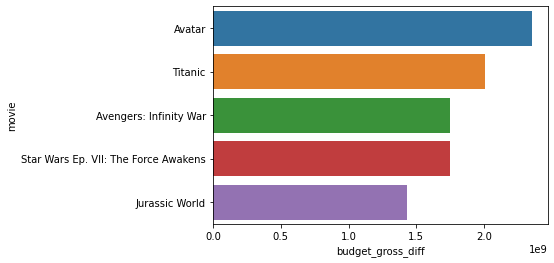

In [24]:
sns.barplot(x = "budget_gross_diff", y = "movie", data = movie_budgets_df_top50[:5])

# Exploring the percent of return 

We realized that with this direct dollar value we are ignoring any movies that might have made a little less money at the box office. Hence we are interested in exploring the percent of return on the production budget

In [25]:
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff
id,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395
7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864


For getting the percent of return we just need to divide the new column we created by the production budget and store the values in a new column

In [26]:
movie_budgets_df['roi'] = movie_budgets_df['budget_gross_diff'] / movie_budgets_df['production_budget']

In [27]:
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
id,,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577
43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395,10.041042
7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,5.827114
6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,5.710167
34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,6.669092


In [28]:
movie_budgets_df = movie_budgets_df.sort_values(by='roi', ascending=False)

In [29]:
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
id,,,,,,,
46,"Jun 30, 1972",Deep Throat,25000,45000000,45000000,44975000,1799.000000
14,"Mar 21, 1980",Mad Max,200000,8750000,99750000,99550000,497.750000
93,"Sep 25, 2009",Paranormal Activity,450000,107918810,194183034,193733034,430.517853
80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,41556474,415.564740
7,"Jul 14, 1999",The Blair Witch Project,600000,140539099,248300000,247700000,412.833333


In [30]:
movie_budgets_df.isna().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
budget_gross_diff    0
roi                  0
dtype: int64

We now have a dataframe sorted by the return on the production budget that we started with

Main problem we run into now is that we have movies with really low budgets coming at the top. We know Microsoft will want to enter the movie industry with a bang and we are assuming they will have a budget of at least $10 million.

We will ignore any movies with a budget smaller than that

In [31]:
movie_budgets_df = movie_budgets_df[movie_budgets_df['production_budget'] > 10000000]

In [32]:
movie_budgets_df.shape

(3535, 7)

In [33]:
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
id,,,,,,,
26,"Jun 11, 1982",ET: The Extra-Terrestrial,10500000,435110554,792965326,782465326,74.520507
65,"May 25, 1977",Star Wars Ep. IV: A New Hope,11000000,460998007,786598007,775598007,70.508910
18,"May 25, 2012",Les Intouchables,10800000,13182281,484873045,474073045,43.895652
41,"Jun 20, 1975",Jaws,12000000,260000000,470700000,458700000,38.225000
42,"Dec 26, 1973",The Exorcist,12000000,230347346,428214478,416214478,34.684540


<AxesSubplot:xlabel='roi', ylabel='movie'>

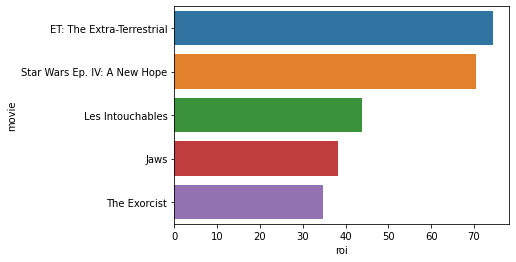

In [34]:
sns.barplot(x = "roi", y = "movie", data = movie_budgets_df[:5])

# What are the most popular genres?

### Bringing in a dataframe with genre details

Now that we have the movies, having some more information about the movies like their genre will give us some advanced insights

In [35]:
#title basics df will have all the required info
imdb_title_basics_df = csv_files_dict['imdb_title_basics_gz']

In [36]:
imdb_title_basics_df.head()

,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [37]:
#using merge and using a left join. As col names are different, using left_on and right_on options

movie_details_df = pd.merge(movie_budgets_df_top50, imdb_title_basics_df, left_on=  ['movie'],
                   right_on= ['primary_title'], 
                   how = 'left')

In [38]:
movie_details_df.shape

(58, 11)

In [39]:
movie_details_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       58 non-null     object 
 1   movie              58 non-null     object 
 2   production_budget  58 non-null     int64  
 3   domestic_gross     58 non-null     int64  
 4   worldwide_gross    58 non-null     int64  
 5   budget_gross_diff  58 non-null     int64  
 6   primary_title      43 non-null     object 
 7   original_title     43 non-null     object 
 8   start_year         43 non-null     float64
 9   runtime_minutes    41 non-null     float64
 10  genres             43 non-null     object 
dtypes: float64(2), int64(4), object(5)
memory usage: 5.4+ KB


In [40]:
movie_details_df.dropna(inplace = True)

In [41]:
movie_details_df.shape

(41, 11)

In [42]:
movie_details_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,primary_title,original_title,start_year,runtime_minutes,genres
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,Avatar,Abatâ,2011.0,93.0,Horror
2,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395,Titanic,Titanic,2018.0,115.0,Family
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,Avengers: Infinity War,Avengers: Infinity War,2018.0,149.0,"Action,Adventure,Sci-Fi"
5,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,Jurassic World,Jurassic World,2015.0,124.0,"Action,Adventure,Sci-Fi"
6,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,Furious 7,Furious Seven,2015.0,137.0,"Action,Crime,Thriller"


We notice that some of the records are not joined correctly. We will try to rectify this by leveraging the release year and trying to join based on that as well

### Adding release year to the join to get more relevant results

In [43]:
movie_budgets_df_top50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 26
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       50 non-null     object
 1   movie              50 non-null     object
 2   production_budget  50 non-null     int64 
 3   domestic_gross     50 non-null     int64 
 4   worldwide_gross    50 non-null     int64 
 5   budget_gross_diff  50 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ KB


In [44]:
movie_budgets_df_top50['release_year'] = pd.to_datetime(movie_budgets_df_top50['release_date']).dt.year

In [45]:
movie_budgets_df_top50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 26
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       50 non-null     object
 1   movie              50 non-null     object
 2   production_budget  50 non-null     int64 
 3   domestic_gross     50 non-null     int64 
 4   worldwide_gross    50 non-null     int64 
 5   budget_gross_diff  50 non-null     int64 
 6   release_year       50 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 3.1+ KB


In [46]:
movie_budgets_df_top50.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,release_year
id,,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,2009
43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395,1997
7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,2018
6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,2015
34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,2015


In [47]:
movie_details_df2 = pd.merge(movie_budgets_df_top50, imdb_title_basics_df, left_on=  ['movie', 'release_year'],
                   right_on= ['primary_title', 'start_year'], 
                   how = 'left')

In [48]:
movie_details_df2.shape

(51, 12)

In [49]:
movie_details_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       51 non-null     object 
 1   movie              51 non-null     object 
 2   production_budget  51 non-null     int64  
 3   domestic_gross     51 non-null     int64  
 4   worldwide_gross    51 non-null     int64  
 5   budget_gross_diff  51 non-null     int64  
 6   release_year       51 non-null     int64  
 7   primary_title      33 non-null     object 
 8   original_title     33 non-null     object 
 9   start_year         33 non-null     float64
 10  runtime_minutes    33 non-null     float64
 11  genres             33 non-null     object 
dtypes: float64(2), int64(5), object(5)
memory usage: 5.2+ KB


In [50]:
movie_details_df2.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,release_year,primary_title,original_title,start_year,runtime_minutes,genres
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,2009,NaN,NaN,NaN,NaN,NaN
1,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395,1997,NaN,NaN,NaN,NaN,NaN
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,2018,Avengers: Infinity War,Avengers: Infinity War,2018.0,149.0,"Action,Adventure,Sci-Fi"
3,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,2015,NaN,NaN,NaN,NaN,NaN
4,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,2015,Jurassic World,Jurassic World,2015.0,124.0,"Action,Adventure,Sci-Fi"


In [51]:
movie_details_df2.dropna(inplace=True)

In [52]:
movie_details_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 2 to 49
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       33 non-null     object 
 1   movie              33 non-null     object 
 2   production_budget  33 non-null     int64  
 3   domestic_gross     33 non-null     int64  
 4   worldwide_gross    33 non-null     int64  
 5   budget_gross_diff  33 non-null     int64  
 6   release_year       33 non-null     int64  
 7   primary_title      33 non-null     object 
 8   original_title     33 non-null     object 
 9   start_year         33 non-null     float64
 10  runtime_minutes    33 non-null     float64
 11  genres             33 non-null     object 
dtypes: float64(2), int64(5), object(5)
memory usage: 3.4+ KB


We did lose information about some of the highest grossing films but those films were being matched inaccurately and that would've led us to having incorrect conclusions

In [53]:
movie_details_df2.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,release_year,primary_title,original_title,start_year,runtime_minutes,genres
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,2018,Avengers: Infinity War,Avengers: Infinity War,2018.0,149.0,"Action,Adventure,Sci-Fi"
4,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,2015,Jurassic World,Jurassic World,2015.0,124.0,"Action,Adventure,Sci-Fi"
5,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,2015,Furious 7,Furious Seven,2015.0,137.0,"Action,Crime,Thriller"
6,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1292935897,2012,The Avengers,The Avengers,2012.0,143.0,"Action,Adventure,Sci-Fi"
8,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1148258224,2018,Black Panther,Black Panther,2018.0,134.0,"Action,Adventure,Sci-Fi"


In [54]:
#movie_details_df2['genres'] = movie_details_df2['genres'].astype(str)

### Creating a separate column for each genre

In [55]:
#genre is a list of upto 3 genres, splitting it to get the individual genres

movie_details_df2['genres'] = movie_details_df2['genres'].apply(lambda x: x.split(",") if x else x)

In [56]:
movie_details_df2.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,release_year,primary_title,original_title,start_year,runtime_minutes,genres
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,2018,Avengers: Infinity War,Avengers: Infinity War,2018.0,149.0,"[Action, Adventure, Sci-Fi]"
4,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,2015,Jurassic World,Jurassic World,2015.0,124.0,"[Action, Adventure, Sci-Fi]"
5,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,2015,Furious 7,Furious Seven,2015.0,137.0,"[Action, Crime, Thriller]"
6,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1292935897,2012,The Avengers,The Avengers,2012.0,143.0,"[Action, Adventure, Sci-Fi]"
8,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1148258224,2018,Black Panther,Black Panther,2018.0,134.0,"[Action, Adventure, Sci-Fi]"


In [57]:
movie_details_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 2 to 49
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       33 non-null     object 
 1   movie              33 non-null     object 
 2   production_budget  33 non-null     int64  
 3   domestic_gross     33 non-null     int64  
 4   worldwide_gross    33 non-null     int64  
 5   budget_gross_diff  33 non-null     int64  
 6   release_year       33 non-null     int64  
 7   primary_title      33 non-null     object 
 8   original_title     33 non-null     object 
 9   start_year         33 non-null     float64
 10  runtime_minutes    33 non-null     float64
 11  genres             33 non-null     object 
dtypes: float64(2), int64(5), object(5)
memory usage: 3.4+ KB


In [58]:
#making a set of all genres we have. set doesn't allow duplicate values

all_genres = set()
for genres in movie_details_df2['genres']:
    if genres:
        all_genres.update(genres)

In [59]:
all_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Music',
 'Musical',
 'Sci-Fi',
 'Thriller'}

In [60]:
#adding cols with zeros for all the genres we have. Will modify genre to 1 if the film is of that genre.

for genre in all_genres:
    movie_details_df2[genre] = np.zeros(shape=movie_details_df2.shape[0])
                                
movie_details_df2.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,release_year,primary_title,original_title,start_year,...,Comedy,Family,Sci-Fi,Animation,Music,Biography,Adventure,Musical,Action,Thriller
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,2018,Avengers: Infinity War,Avengers: Infinity War,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,2015,Jurassic World,Jurassic World,2015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,2015,Furious 7,Furious Seven,2015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1292935897,2012,The Avengers,The Avengers,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1148258224,2018,Black Panther,Black Panther,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
#setting the genre to be 1 if the film is of that genre

for index, row in movie_details_df2.iterrows():
    if row['genres']:
        for genre in row['genres']:
            movie_details_df2.loc[index, genre] = 1

movie_details_df2.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,release_year,primary_title,original_title,start_year,...,Comedy,Family,Sci-Fi,Animation,Music,Biography,Adventure,Musical,Action,Thriller
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,2018,Avengers: Infinity War,Avengers: Infinity War,2018.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,2015,Jurassic World,Jurassic World,2015.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,2015,Furious 7,Furious Seven,2015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1292935897,2012,The Avengers,The Avengers,2012.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1148258224,2018,Black Panther,Black Panther,2018.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [62]:
movie_details_df_modified = movie_details_df2.drop(columns = 'genres')

In [63]:
#checking the counts for all different genres

for col in movie_details_df_modified:
    print(f'Viewing values in col: {col}')
    print(f'Top 5 values:\n{movie_details_df_modified[col].value_counts()}')

Viewing values in col: release_date
Top 5 values:
Mar 5, 2010     2
Apr 15, 2016    1
Dec 16, 2016    1
Jul 20, 2012    1
Apr 14, 2017    1
Apr 27, 2018    1
Jun 17, 2016    1
Nov 2, 2018     1
Nov 8, 2012     1
Dec 20, 2017    1
Apr 3, 2015     1
Jun 29, 2011    1
Jun 12, 2015    1
Feb 16, 2018    1
Dec 21, 2018    1
Jul 8, 2016     1
Mar 17, 2017    1
Mar 4, 2016     1
Mar 8, 2019     1
Jul 10, 2015    1
Nov 22, 2013    1
May 4, 2012     1
May 6, 2016     1
May 3, 2013     1
Jul 3, 2013     1
Jun 27, 2014    1
Jul 13, 2012    1
Jun 15, 2018    1
Jun 18, 2010    1
May 1, 2015     1
Jun 30, 2017    1
Jun 22, 2018    1
Name: release_date, dtype: int64
Viewing values in col: movie
Top 5 values:
Alice in Wonderland                2
The Dark Knight Rises              1
Jurassic World                     1
Incredibles 2                      1
Aquaman                            1
Beauty and the Beast               1
Furious 7                          1
Ice Age: Continental Drift         1
Bo

Name: Adventure, dtype: int64
Viewing values in col: Musical
Top 5 values:
0.0    31
1.0     2
Name: Musical, dtype: int64
Viewing values in col: Action
Top 5 values:
1.0    19
0.0    14
Name: Action, dtype: int64
Viewing values in col: Thriller
Top 5 values:
0.0    29
1.0     4
Name: Thriller, dtype: int64


In [64]:
#making a list of all genres

cols = list(movie_details_df2.columns)

In [65]:
genre_cols = cols[12:]

In [66]:
#getting a dict with genre counts

genre_count = {}
for col in genre_cols:
    count = np.sum(movie_details_df2[col] == 1).sum() 
    genre_count[col] = count

In [67]:
genre_count

{'Drama': 2,
 'Fantasy': 4,
 'Crime': 2,
 'Comedy': 10,
 'Family': 3,
 'Sci-Fi': 12,
 'Animation': 10,
 'Music': 1,
 'Biography': 1,
 'Adventure': 27,
 'Musical': 2,
 'Action': 19,
 'Thriller': 4}

In [68]:
keys = list(genre_count.keys())
values = list(genre_count.values())

### Plot of movie counts by genre

<AxesSubplot:>

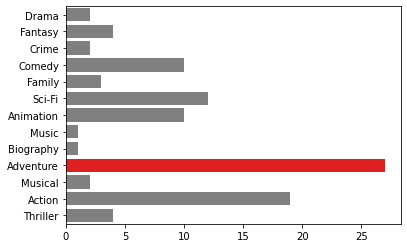

In [69]:
clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y = keys, x = values, palette=clrs)

### Some cleaning of the df before further analysis

In [70]:
movie_details_df2.drop(columns=['genres'], inplace=True)

In [71]:
movie_details_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 2 to 49
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       33 non-null     object 
 1   movie              33 non-null     object 
 2   production_budget  33 non-null     int64  
 3   domestic_gross     33 non-null     int64  
 4   worldwide_gross    33 non-null     int64  
 5   budget_gross_diff  33 non-null     int64  
 6   release_year       33 non-null     int64  
 7   primary_title      33 non-null     object 
 8   original_title     33 non-null     object 
 9   start_year         33 non-null     float64
 10  runtime_minutes    33 non-null     float64
 11  Drama              33 non-null     float64
 12  Fantasy            33 non-null     float64
 13  Crime              33 non-null     float64
 14  Comedy             33 non-null     float64
 15  Family             33 non-null     float64
 16  Sci-Fi             33 non-nu

In [72]:
movie_details_df2.drop(columns=['primary_title', 'original_title', 'start_year'], inplace=True)

In [73]:
movie_details_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 2 to 49
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       33 non-null     object 
 1   movie              33 non-null     object 
 2   production_budget  33 non-null     int64  
 3   domestic_gross     33 non-null     int64  
 4   worldwide_gross    33 non-null     int64  
 5   budget_gross_diff  33 non-null     int64  
 6   release_year       33 non-null     int64  
 7   runtime_minutes    33 non-null     float64
 8   Drama              33 non-null     float64
 9   Fantasy            33 non-null     float64
 10  Crime              33 non-null     float64
 11  Comedy             33 non-null     float64
 12  Family             33 non-null     float64
 13  Sci-Fi             33 non-null     float64
 14  Animation          33 non-null     float64
 15  Music              33 non-null     float64
 16  Biography          33 non-nu

In [74]:
movie_details_df2.reset_index(inplace=True)

In [75]:
movie_details_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              33 non-null     int64  
 1   release_date       33 non-null     object 
 2   movie              33 non-null     object 
 3   production_budget  33 non-null     int64  
 4   domestic_gross     33 non-null     int64  
 5   worldwide_gross    33 non-null     int64  
 6   budget_gross_diff  33 non-null     int64  
 7   release_year       33 non-null     int64  
 8   runtime_minutes    33 non-null     float64
 9   Drama              33 non-null     float64
 10  Fantasy            33 non-null     float64
 11  Crime              33 non-null     float64
 12  Comedy             33 non-null     float64
 13  Family             33 non-null     float64
 14  Sci-Fi             33 non-null     float64
 15  Animation          33 non-null     float64
 16  Music              33 non-nu

In [76]:
movie_details_df2.drop(columns=['index'], inplace= True)

In [77]:
movie_details_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       33 non-null     object 
 1   movie              33 non-null     object 
 2   production_budget  33 non-null     int64  
 3   domestic_gross     33 non-null     int64  
 4   worldwide_gross    33 non-null     int64  
 5   budget_gross_diff  33 non-null     int64  
 6   release_year       33 non-null     int64  
 7   runtime_minutes    33 non-null     float64
 8   Drama              33 non-null     float64
 9   Fantasy            33 non-null     float64
 10  Crime              33 non-null     float64
 11  Comedy             33 non-null     float64
 12  Family             33 non-null     float64
 13  Sci-Fi             33 non-null     float64
 14  Animation          33 non-null     float64
 15  Music              33 non-null     float64
 16  Biography          33 non-nu

In [78]:
ord(a)

NameError: name 'a' is not defined

In [79]:
df_test = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

In [80]:
df_test.head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [81]:
grouped = movie_details_df2.groupby(by = 'Crime').sum()

In [82]:
grouped.iloc[1]["worldwide_gross"]

2753569061.0

In [115]:
worldwide_gross = {}
for genre in all_genres:
    grouped = movie_details_df2.groupby(by = "".join(genre)).mean()
    worldwide_gross[genre] = grouped.iloc[1]["worldwide_gross"]

In [116]:
worldwide_gross = dict(sorted(worldwide_gross.items(), key = lambda item : item[1], reverse = True))

In [124]:
worldwide_gross

{'Crime': 1376784530.5,
 'Sci-Fi': 1335618804.75,
 'Action': 1280519596.9473684,
 'Thriller': 1237133785.25,
 'Adventure': 1177740759.5925925,
 'Musical': 1142345408.0,
 'Fantasy': 1114269141.5,
 'Family': 1082515121.0,
 'Animation': 1056131138.1,
 'Comedy': 1028328686.3,
 'Drama': 928919944.5,
 'Music': 894985342.0,
 'Biography': 894985342.0}

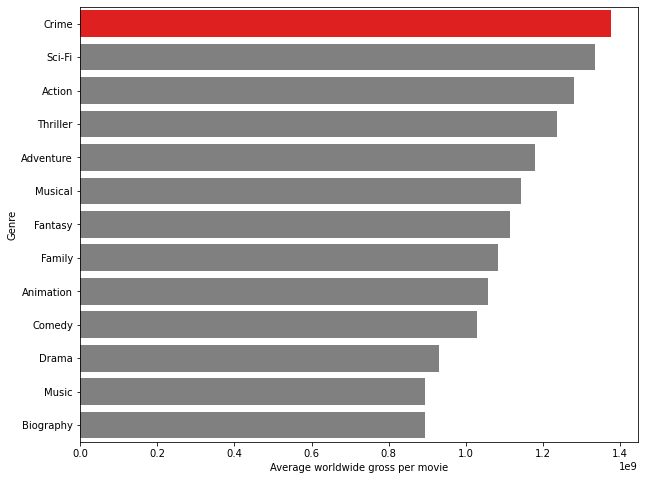

In [130]:
plt.figure(figsize=(10,8))
clrs = ['grey' if (x < max(worldwide_gross.values())) else 'red' for x in worldwide_gross.values() ]
sns.barplot(x = list(worldwide_gross.values()), y = list(worldwide_gross.keys()), palette=clrs)
plt.xlabel("Average worldwide gross per movie")
plt.ylabel("Genre")
plt.savefig("highest_revenue_per_movie")

In [125]:
clrs

['grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'red',
 'grey',
 'grey',
 'grey']